# Functions to Aggregate Price Change Data and Plot

In [10]:
import requests
import csv
import pandas as pd
import time
def fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes):
    """
    Fetches aggregated volumes and calculates price volatility for the given stock ticker and date range.

    Args:
    - ticker (str): The stock ticker symbol.
    - start_date (str): The start date in the format 'YYYY-MM-DD'.
    - end_date (str): The end date in the format 'YYYY-MM-DD'.
    - interval_minutes (int): The interval in minutes for the aggregation.

    Returns:
    - pd.DataFrame: A DataFrame containing aggregated data with timestamps as index.
    """
    # API query parameters
    api_key = "RLH5skiQVl24hXBE2IyPT3JBDmorI4r0"


    # Construct initial API query URL
    stock_data = {}
    url = f"https://api.polygon.io/v2/aggs/ticker/{ticker}/range/{interval_minutes}/minute/{start_date}/{end_date}?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    params = {
            'apiKey': api_key
        }

    while url:
        # Make the API request
        response = requests.get(url, params=params)
        
        # Check if the request was successful
        if response.status_code == 200:
            # Load JSON data from the response
            data = response.json()
            results = data["results"]

            # Iterate through results and process data
            for result in results:
                timestamp = result["t"]
                num_trades = result["n"]
                high = result["h"]
                low = result["l"]
                open_price = result["o"]
                close = result["c"]
                abs_change = abs(open_price - close)
                max_diff = abs(high - low)
                timestamp_et = pd.to_datetime(timestamp, unit='ms', utc=True).tz_convert('America/New_York')
                timestamp_str = timestamp_et.strftime("%Y-%m-%d %H:%M:%S")
                stock_data[timestamp_str] = {"abs_change": abs_change, "max_diff": max_diff}

            # Update URL for next page if available
            url = data.get('next_url')

            # Delay to comply with rate limit (5 requests per minute)
            time.sleep(12)  # Sleep for 12 seconds between each request

        else:
            print(f"Failed to fetch data. Status code: {response.status_code}")
            break
    
    # Convert dictionary to DataFrame
    df = pd.DataFrame(stock_data).T

    # Save DataFrame to CSV
    df.to_csv(f"{ticker}_aggregated_pc.csv")

    return df

In [11]:
tickers = ['AMZN', 'MSFT', 'TSLA', 'GOOG', 'NVDA', 'META', 'AAPL', 'QQQ', 'SPY', 'AMD']
start_date = '2023-01-01'
end_date = '2024-02-18'
interval_minutes = 15
for ticker in tickers: 
    volumes = fetch_aggregated_pc(ticker, start_date, end_date, interval_minutes)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

def plot_change_and_diff(df, ticker):
    """
    Plots the average volume and number of trades for each 15-minute interval.

    Args:
    - df (DataFrame): DataFrame containing columns 'volume' and 'num_trades'.
                      The DataFrame should have timestamps as the index.
    """
    # Calculate the averages
    readable_timestamps = []
    for hour in range(9, 17):  # Trading hours from 9:00 to 16:00
        for minute in range(0, 60, 15):
            timestamp = f"{hour:02d}:{minute:02d}"
            readable_timestamps.append(timestamp)

    stock_data = {timestamp: {'abs_change': [], 'max_diff': []} for timestamp in readable_timestamps}

    for index, row in df.iterrows():
        values = row[0].split(',')
        timestamp = values[0]
        abs_change = float(values[1])
        max_diff = float(values[2])

        datetime_obj = pd.to_datetime(timestamp)
        timestamp_str = datetime_obj.strftime("%H:%M")

        if timestamp_str in readable_timestamps:
            stock_data[timestamp_str]['abs_change'].append(abs_change)
            stock_data[timestamp_str]['max_diff'].append(max_diff)

    # Calculate averages for each interval
    avg_abs_change = [sum(data['abs_change']) / len(data['abs_change']) if data['abs_change'] else 0 for data in stock_data.values()]
    avg_max_diff = [sum(data['max_diff']) / len(data['max_diff']) if data['max_diff'] else 0 for data in stock_data.values()]

    # Plot the averages
    plt.figure(figsize=(12, 6))

    # Plot the average volume
    plt.plot(readable_timestamps, avg_abs_change, label='Average Absolute Change', marker='o')

    # Plot the average number of trades
    plt.plot(readable_timestamps, avg_max_diff, label='Average Max Difference', marker='o', color='orange')

    # Add labels, title, and legend
    plt.xlabel('Time of the Day (HH:MM)')
    plt.ylabel('Average Absolute Change / Average Max Difference')
    plt.title(f'Average Absolute Change and Average Max Difference for Each 15-minute Interval {ticker}')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    return avg_abs_change, avg_max_diff

In [32]:
import numpy as np

def analyze_pc(avg_abs_change, avg_max_diff, threshold):
    """
    Analyzes the average volumes and number of trades for each 15-minute interval and returns times above a certain threshold.

    Args:
    - avg_volumes (list): A list of average volumes for each 15-minute interval.
    - avg_trades (list): A list of average number of trades for each 15-minute interval.
    - threshold (float): The absolute threshold value for both volume and trades significance.

    Returns:
    - list: A list of timestamps where both volume and trades significance are above the threshold.
    """     
    significant_times = []

    # Calculate overall average and standard deviation
    overall_avg_abs_change = np.mean(avg_abs_change)
    overall_std_abs_change = np.std(avg_abs_change)
    overall_avg_max_diff = np.mean(avg_max_diff)
    overall_std_max_diff = np.std(avg_max_diff)

    # Calculate statistical significance for each interval
    change_significance = (np.array(avg_abs_change) - overall_avg_abs_change) / overall_std_abs_change
    diff_significance = (np.array(avg_max_diff) - overall_avg_max_diff) / overall_std_max_diff

    # Check if both volume and trades significance are above the threshold and add corresponding times to the list
    for i, (change_significance_val, diff_significance_val) in enumerate(zip(change_significance, diff_significance)):
        if abs(change_significance_val) >= threshold and abs(diff_significance_val) >= threshold:
            # Assuming the timestamp format is 'HH:MM' based on the previous code
            timestamp = f"{9 + i // 4:02d}:{i % 4 * 15:02d}"
            significant_times.append(timestamp)

    return significant_times, overall_avg_abs_change, overall_std_abs_change, overall_avg_max_diff, overall_std_max_diff

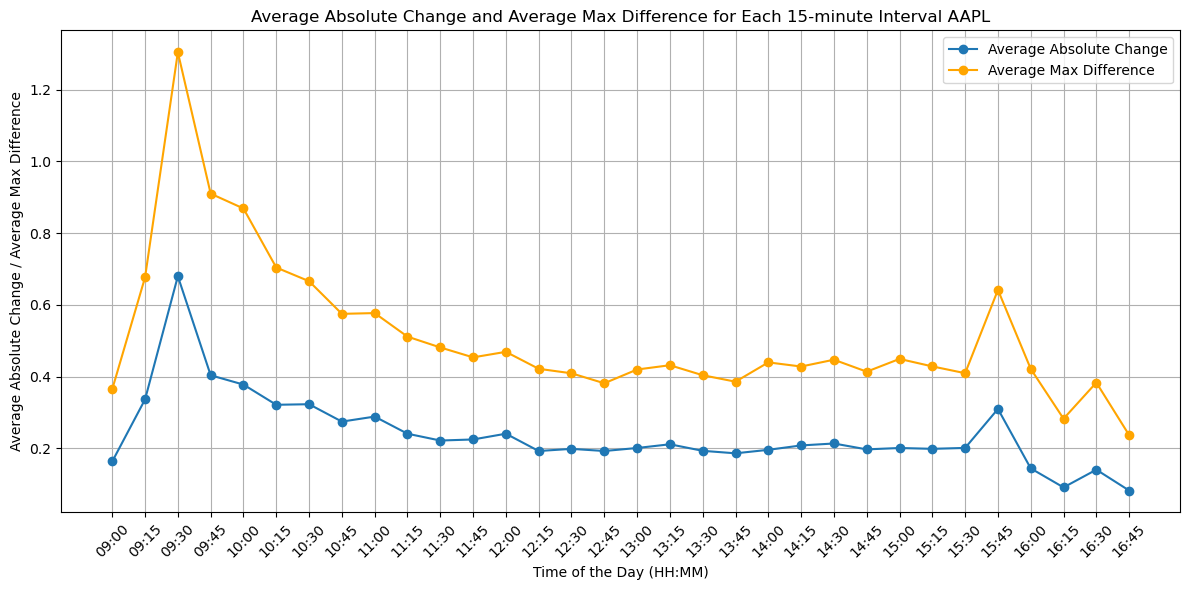

significant times for AAPL
['09:30', '09:45'] 0.23929615724381625


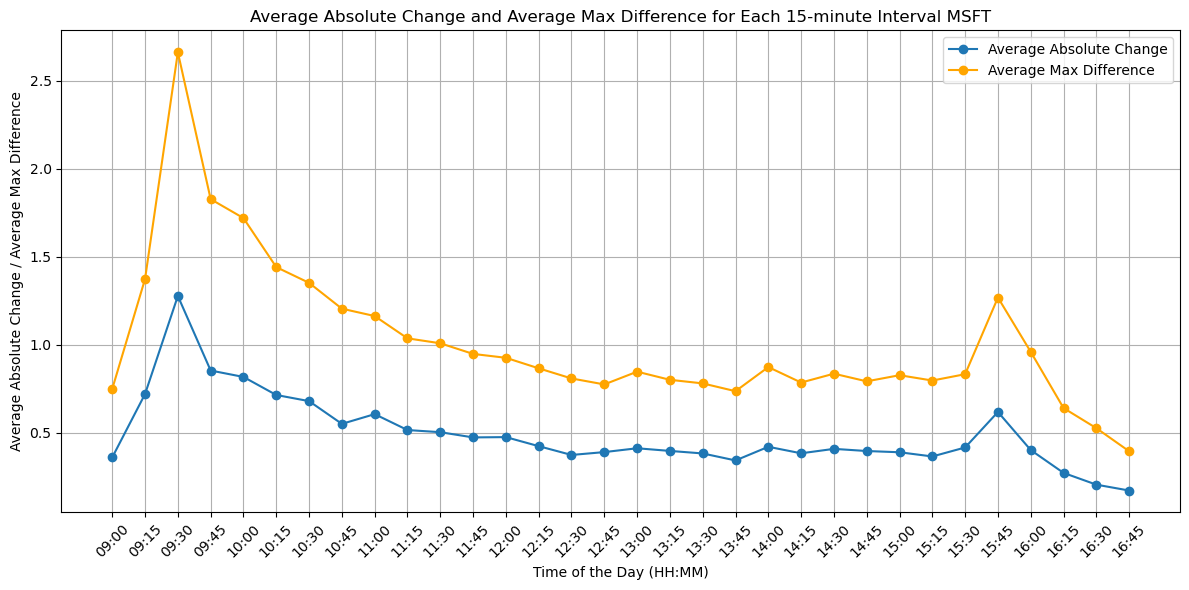

significant times for MSFT
['09:30', '09:45', '10:00'] 0.4896242798552114


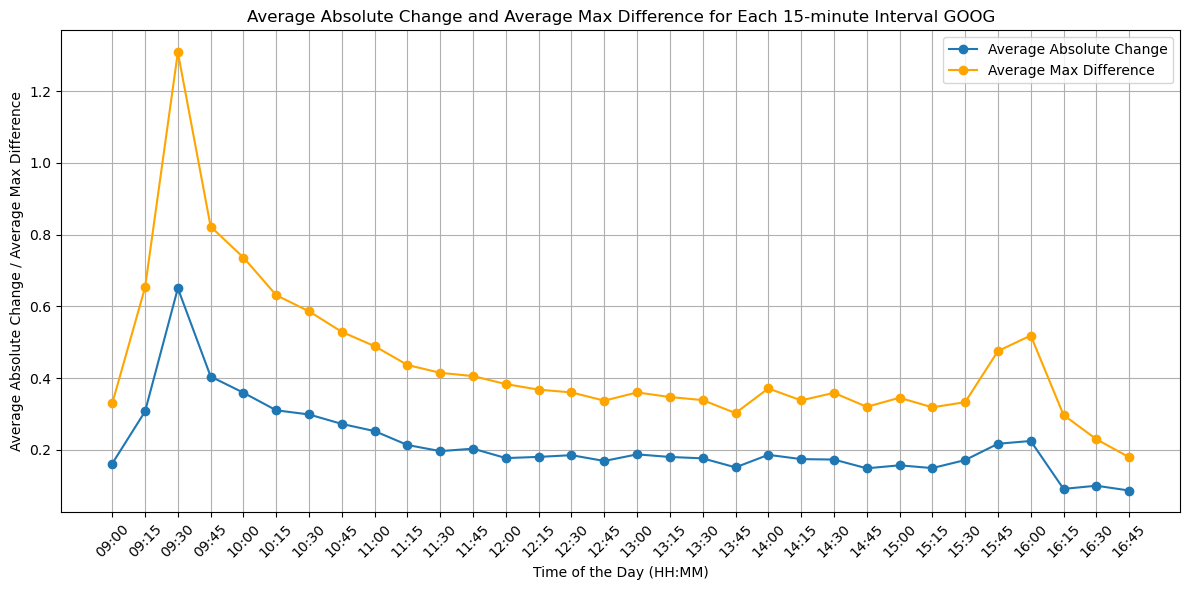

significant times for GOOG
['09:30', '09:45'] 0.21620848553976152


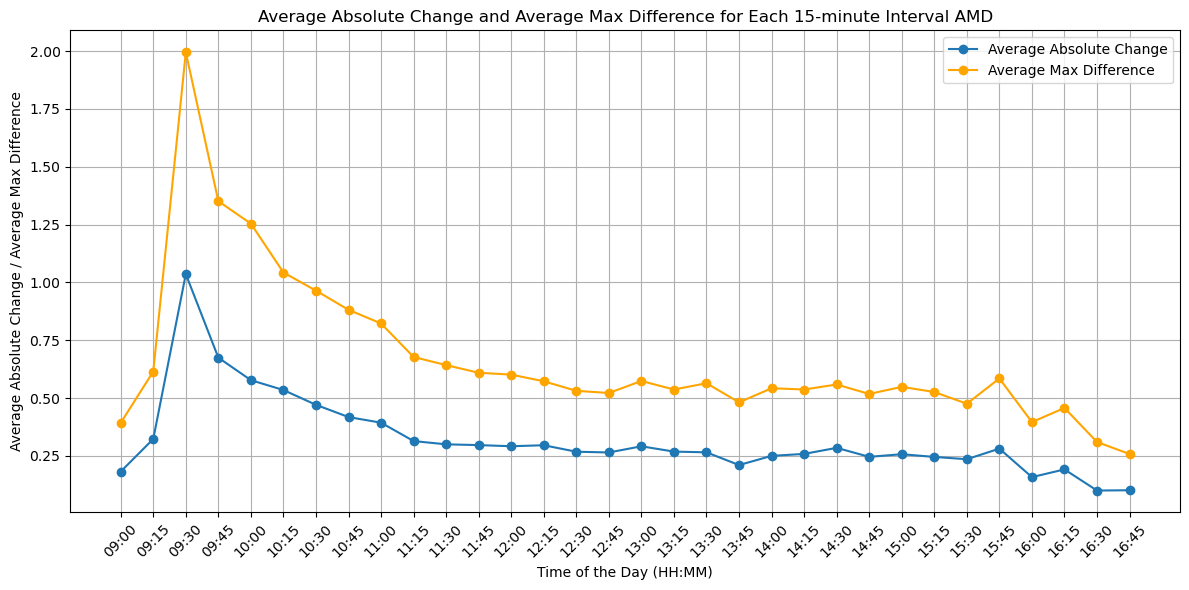

significant times for AMD
['09:30', '09:45'] 0.3218514686395759


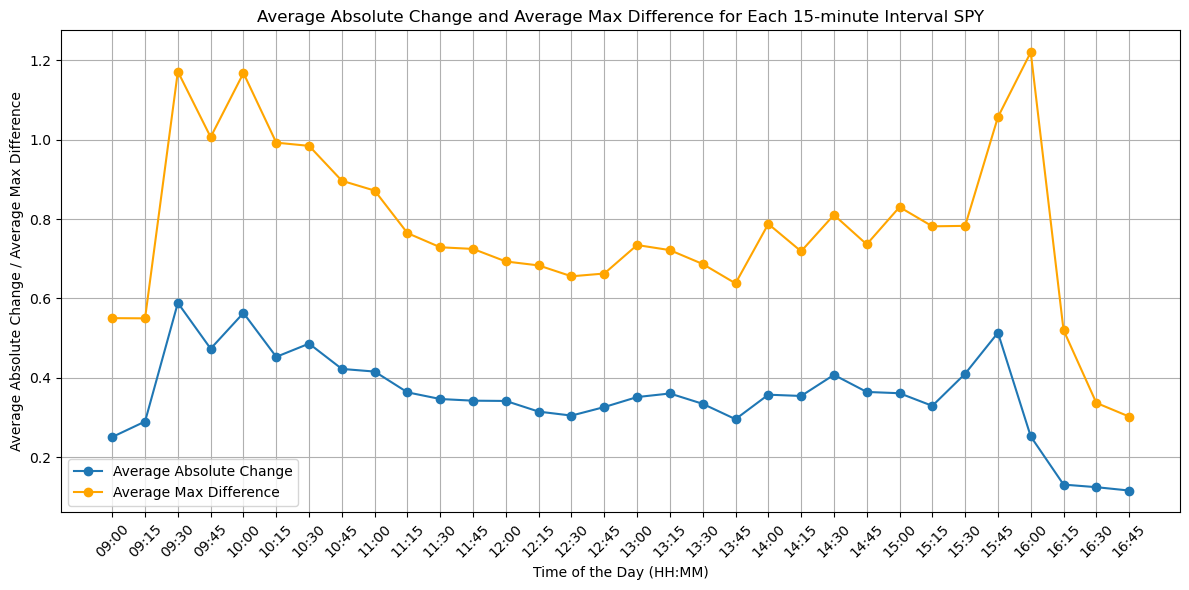

significant times for SPY
['09:30', '10:00', '16:30', '16:45'] 0.3544695781802127


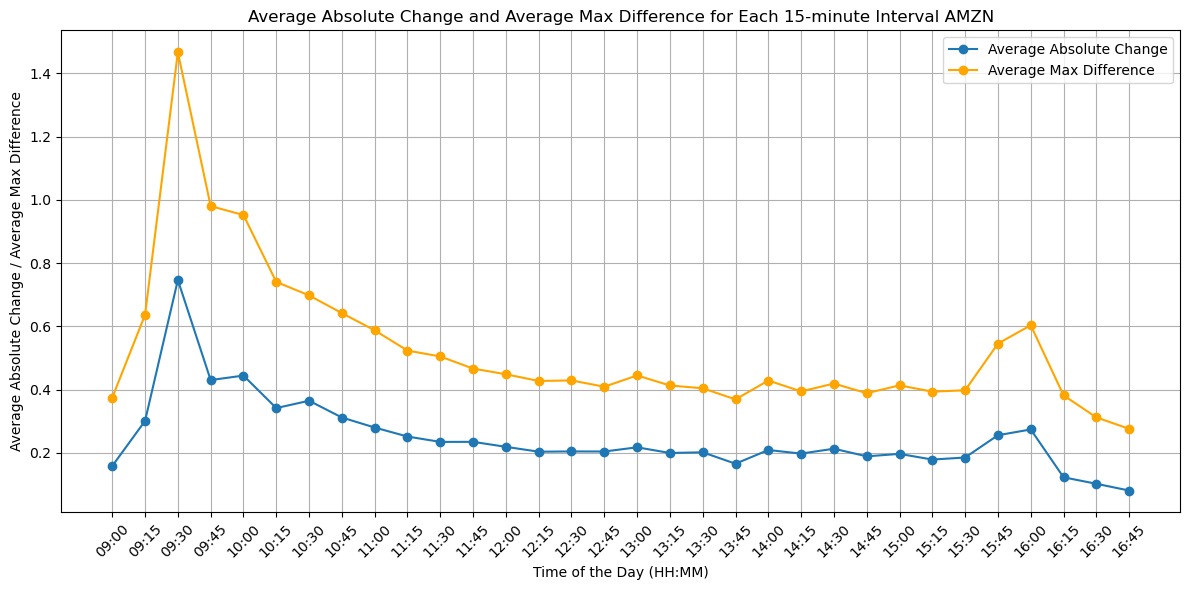

significant times for AMZN
['09:30', '09:45', '10:00'] 0.24725763030035341


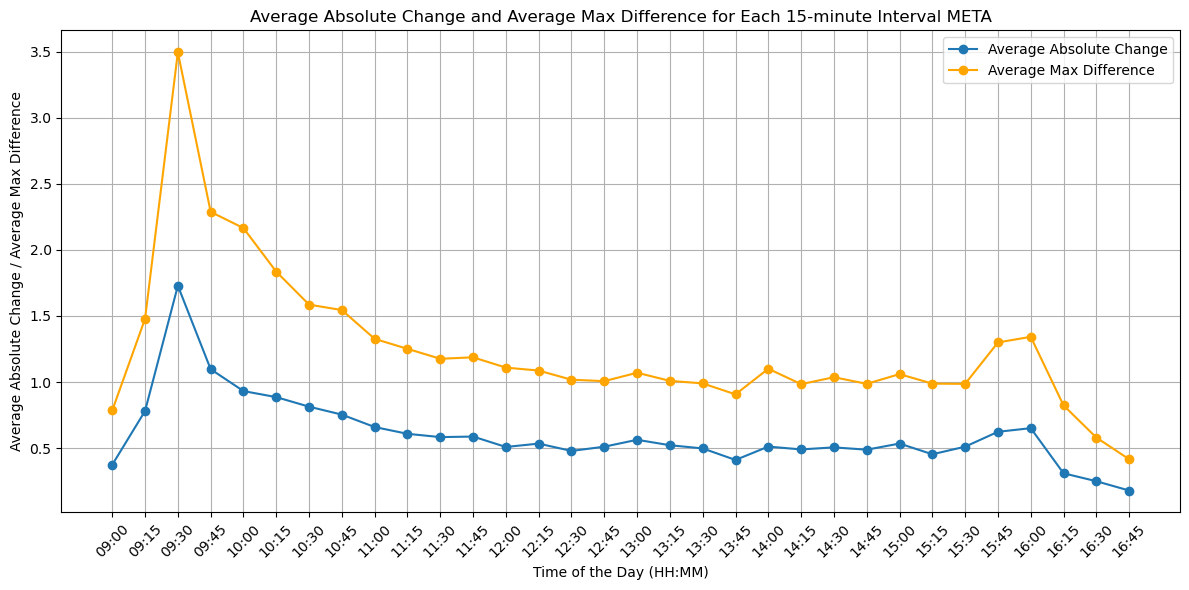

significant times for META
['09:30', '09:45'] 0.6043551329552291


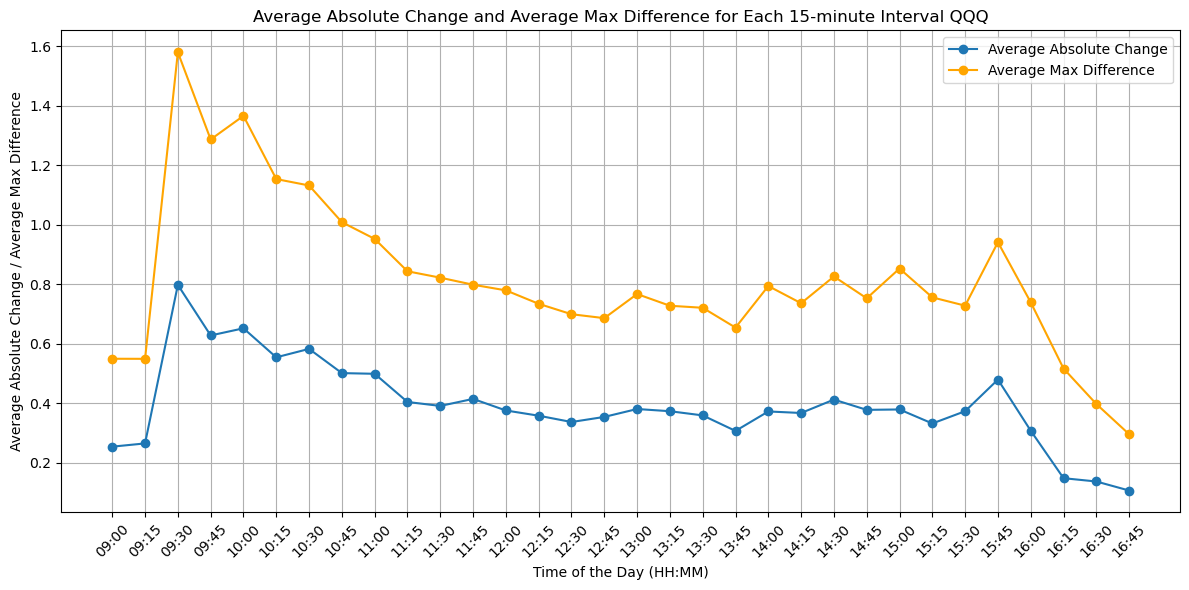

significant times for QQQ
['09:30', '09:45', '10:00', '16:30', '16:45'] 0.393723454063604


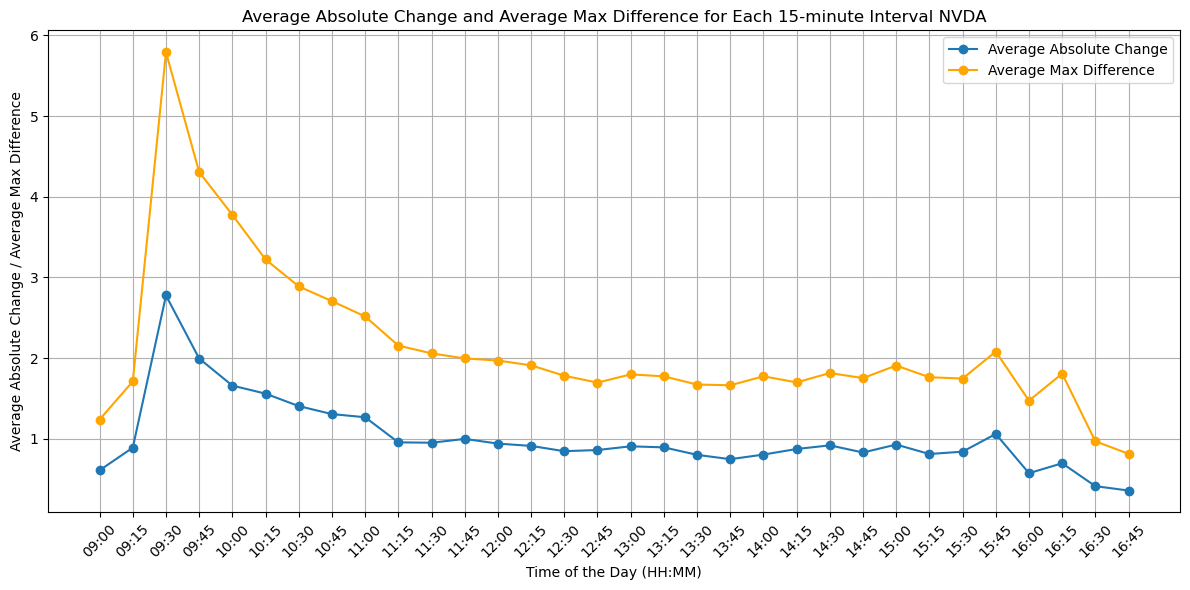

significant times for NVDA
['09:30', '09:45'] 1.0125333149293283


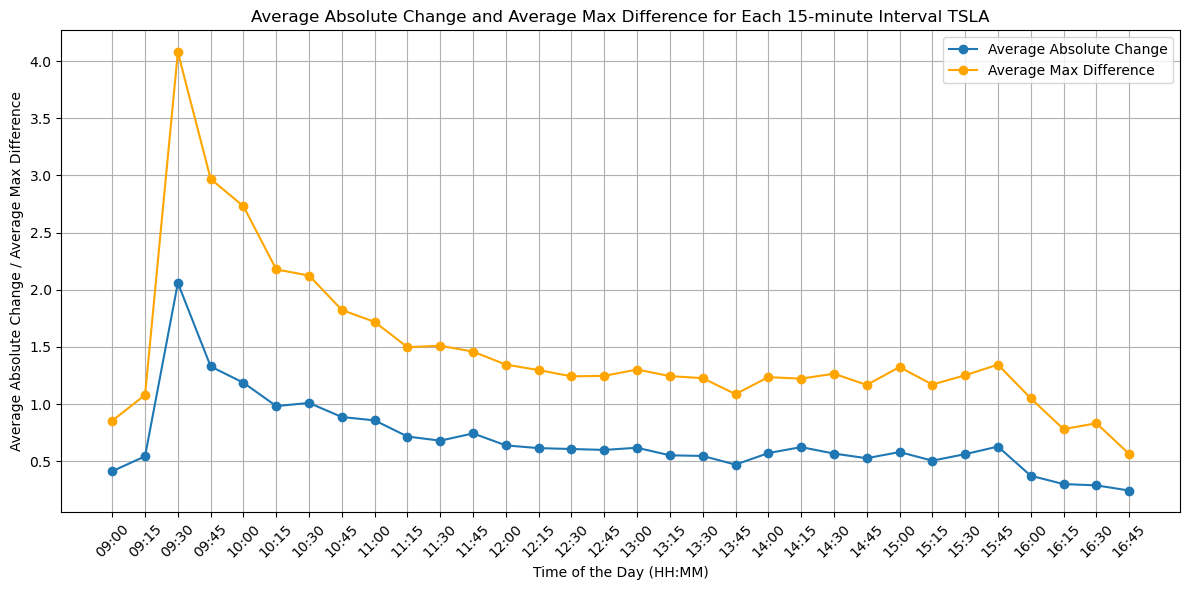

significant times for TSLA
['09:30', '09:45'] 0.6813622018551234


In [34]:
import os
directory = os.getcwd()
threshold = 1.5
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        ticker = filename.split('_')[0]
        df = pd.read_csv(filename, sep='\t')
        avg_abs_change, avg_max_diff = plot_change_and_diff(df, ticker)
        significant_times, overall_avg_abs_change, overall_std_abs_change, overall_avg_max_diff, overall_std_max_diff = analyze_pc(avg_abs_change, avg_max_diff, threshold)
        print("significant times for " + ticker)
        print(significant_times, overall_avg_abs_change)